In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, cross_val_score,cross_validate, RandomizedSearchCV, train_test_split
import optuna
import xgboost as xgb
from sklearn.metrics import r2_score 
import joblib

In [3]:
df2 = pd.read_excel("../markaFile/MINI.xlsx",sheet_name="Sheet1")

In [4]:
df2.drop(df2[(df2["Fiyat"] > 1500000)].index, axis=0, inplace=True)

In [5]:
df2.drop("Unnamed: 0",axis=1, inplace=True)

In [6]:
df2.head()

,Fiyat,Yıl,Motor Gücü,Motor Hacmi,Kilometre,Boya,Değişen,Seri_Cooper,Seri_Cooper Clubman,Seri_Cooper S,...,Model_1.6 D,Model_1.6 S,Model_2.0,Model_2.0 Works,Model_2.0 Works Iconic,Yakıt Tipi_Benzin,Yakıt Tipi_Dizel,Yakıt Tipi_LPG & Benzin,Vites Tipi_Düz,Vites Tipi_Otomatik
0,1400000,0.818182,0.388889,-0.307692,-0.951311,NaN,NaN,0,1,0,...,0,0,0,0,0,0,1,0,0,1
1,377500,-0.454545,0.500000,0.182692,0.449438,NaN,NaN,1,0,0,...,0,0,0,0,0,0,0,1,1,0
2,865000,0.545455,0.388889,-0.307692,-0.606742,0.0,0.0,1,0,0,...,0,0,0,0,0,0,1,0,0,1
3,325000,-0.545455,0.361111,0.182692,0.067416,NaN,NaN,1,0,0,...,0,0,0,0,0,1,0,0,1,0
4,420000,-0.272727,2.027778,0.182692,0.561798,NaN,NaN,0,0,1,...,0,0,0,0,0,1,0,0,1,0


In [7]:
y = df2["Fiyat"]
X = df2.drop(["Fiyat"], axis=1)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

In [9]:
def set_model(model_list, X_train, X_test, y_train, y_test):
    dataf = pd.DataFrame()

    for i in range(len(model_list)):
        algo_name = model_list[i][0]
        algo = model_list[i][1]

        model = algo.fit(X_train, y_train)

        cv_result = cross_val_score(model,
                                    X_train, y_train,
                                    cv=5,
                                    scoring="neg_mean_squared_error")

        y_pred = model.predict(X_test)
        rmse = np.mean(np.sqrt(-cv_result))
        data_list = {"Model": algo_name,
                     "TestDeger": rmse,
                     "MSE":mean_squared_error(y_test, y_pred),
                     "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
                     "MAE": mean_absolute_error(y_test, y_pred)}
        dataf = dataf.append(data_list, ignore_index=True)

    return dataf

In [10]:
models = []
#models.append(('Gradient Boosting Regressor', GradientBoostingRegressor()))
models.append(('XGBModel', XGBRegressor(objective="reg:squarederror",use_label_encoder=False)))
#models.append(('LGBMModel', LGBMRegressor(use_missing=False)))
#models.append(('LRModel', LinearRegression()))
#models.append(('RFModel', RandomForestRegressor()))

In [11]:
df2_model = set_model(models, X_train, X_test, y_train, y_test)
df2_model

C:\Users\senab\AppData\Local\Temp\ipykernel_15900\3059390516.py:22: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  dataf = dataf.append(data_list, ignore_index=True)


,Model,TestDeger,MSE,RMSE,MAE
0,XGBModel,93164.079811,1.356962e+10,116488.716245,75586.289583


In [12]:
def objective(n_trials):
  params = {
        'colsample_bytree': n_trials.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
        'subsample': n_trials.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
        "learning_rate": n_trials.suggest_float("learning_rate", 1e-4, 0.5, log=True),
        'n_estimators': 10000,
        "max_depth": n_trials.suggest_int("max_depth", 3, 15),
        'min_child_weight': n_trials.suggest_int('min_child_weight', 1, 300),
    }
  dtrain = xgb.DMatrix(data = X_train, label = y_train)
  dval = xgb.DMatrix(data = X_test, label = y_test)

  regressor = xgb.train(params, dtrain) 
  y_pred = regressor.predict(dval)
  rmse = mean_squared_error(y_test, y_pred, squared=False)

  return rmse

In [13]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=250, n_jobs=-1)

[I 2023-05-23 21:13:25,302] A new study created in memory with name: no-name-08a4d19d-4b4b-45b3-9b1a-32e913c70424
[I 2023-05-23 21:13:25,393] Trial 0 finished with value: 648825.3906318581 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.4, 'learning_rate': 0.023213049484359375, 'max_depth': 13, 'min_child_weight': 158}. Best is trial 0 with value: 648825.3906318581.
[I 2023-05-23 21:13:25,395] Trial 1 finished with value: 648825.3906318581 and parameters: {'colsample_bytree': 0.5, 'subsample': 0.7, 'learning_rate': 0.0004036149948186435, 'max_depth': 7, 'min_child_weight': 274}. Best is trial 0 with value: 648825.3906318581.
[I 2023-05-23 21:13:25,400] Trial 4 finished with value: 648825.3906318581 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.6, 'learning_rate': 0.010468306319107872, 'max_depth': 5, 'min_child_weight': 164}. Best is trial 0 with value: 648825.3906318581.
[I 2023-05-23 21:13:25,402] Trial 2 finished with value: 640230.3226856578 and parameters: {'co

[I 2023-05-23 21:13:26,268] Trial 30 finished with value: 648825.3906318581 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.11049131135695194, 'max_depth': 3, 'min_child_weight': 121}. Best is trial 16 with value: 116963.167876402.
[I 2023-05-23 21:13:26,294] Trial 31 finished with value: 648825.3906318581 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.129812275418283, 'max_depth': 3, 'min_child_weight': 119}. Best is trial 16 with value: 116963.167876402.
[I 2023-05-23 21:13:26,352] Trial 34 finished with value: 273439.7169156488 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.14012462888552513, 'max_depth': 6, 'min_child_weight': 50}. Best is trial 16 with value: 116963.167876402.
[I 2023-05-23 21:13:26,383] Trial 32 finished with value: 648825.3906318581 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.13459952253356608, 'max_depth': 7, 'min_child_weight': 109}

[I 2023-05-23 21:13:27,638] Trial 60 finished with value: 252217.8686769671 and parameters: {'colsample_bytree': 0.4, 'subsample': 1.0, 'learning_rate': 0.32749127694346924, 'max_depth': 4, 'min_child_weight': 60}. Best is trial 16 with value: 116963.167876402.
[I 2023-05-23 21:13:27,642] Trial 61 finished with value: 648825.3906318581 and parameters: {'colsample_bytree': 0.4, 'subsample': 0.5, 'learning_rate': 0.07366831352007086, 'max_depth': 4, 'min_child_weight': 62}. Best is trial 16 with value: 116963.167876402.
[I 2023-05-23 21:13:27,678] Trial 62 finished with value: 648825.3906318581 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.06618859674579387, 'max_depth': 4, 'min_child_weight': 66}. Best is trial 16 with value: 116963.167876402.
[I 2023-05-23 21:13:27,703] Trial 63 finished with value: 648825.3906318581 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.5, 'learning_rate': 0.0824242720154917, 'max_depth': 5, 'min_child_weight': 64}. 

[I 2023-05-23 21:13:29,007] Trial 90 finished with value: 120881.00873875889 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.25581357081770295, 'max_depth': 9, 'min_child_weight': 15}. Best is trial 16 with value: 116963.167876402.
[I 2023-05-23 21:13:29,071] Trial 91 finished with value: 648825.3906318581 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.24833667251590147, 'max_depth': 9, 'min_child_weight': 238}. Best is trial 16 with value: 116963.167876402.
[I 2023-05-23 21:13:29,153] Trial 92 finished with value: 129382.78438081432 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.255703513419673, 'max_depth': 9, 'min_child_weight': 16}. Best is trial 16 with value: 116963.167876402.
[I 2023-05-23 21:13:29,189] Trial 93 finished with value: 251240.01012640563 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.2632776147848925, 'max_depth': 9, 'min_child_weight': 40}

[I 2023-05-23 21:13:30,459] Trial 120 finished with value: 253232.9809535887 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.4121218459545802, 'max_depth': 11, 'min_child_weight': 52}. Best is trial 112 with value: 114268.0278855688.
[I 2023-05-23 21:13:30,563] Trial 121 finished with value: 253230.4737350197 and parameters: {'colsample_bytree': 0.8, 'subsample': 1.0, 'learning_rate': 0.411776336434676, 'max_depth': 11, 'min_child_weight': 37}. Best is trial 112 with value: 114268.0278855688.
[I 2023-05-23 21:13:30,633] Trial 122 finished with value: 252283.3634291818 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.4262399123950905, 'max_depth': 9, 'min_child_weight': 39}. Best is trial 112 with value: 114268.0278855688.
[I 2023-05-23 21:13:30,637] Trial 123 finished with value: 253560.45202700543 and parameters: {'colsample_bytree': 0.8, 'subsample': 0.6, 'learning_rate': 0.44606255021821345, 'max_depth': 9, 'min_child_weig

[I 2023-05-23 21:13:31,947] Trial 149 finished with value: 146532.73069594914 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.21774766227273282, 'max_depth': 10, 'min_child_weight': 23}. Best is trial 112 with value: 114268.0278855688.
[I 2023-05-23 21:13:31,989] Trial 151 finished with value: 150191.43190041438 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.20839527511909792, 'max_depth': 10, 'min_child_weight': 24}. Best is trial 112 with value: 114268.0278855688.
[I 2023-05-23 21:13:32,142] Trial 152 finished with value: 141202.22585977052 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.2005695965378849, 'max_depth': 9, 'min_child_weight': 2}. Best is trial 112 with value: 114268.0278855688.
[I 2023-05-23 21:13:32,200] Trial 155 finished with value: 138874.35359782667 and parameters: {'colsample_bytree': 0.3, 'subsample': 1.0, 'learning_rate': 0.26844669453755476, 'max_depth': 11, 'min_chil

[I 2023-05-23 21:13:33,546] Trial 179 finished with value: 117340.75333076809 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.4734418188748696, 'max_depth': 12, 'min_child_weight': 9}. Best is trial 171 with value: 113321.24418544007.
[I 2023-05-23 21:13:33,652] Trial 181 finished with value: 113295.73625050105 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.4329975709539934, 'max_depth': 12, 'min_child_weight': 10}. Best is trial 181 with value: 113295.73625050105.
[I 2023-05-23 21:13:33,662] Trial 182 finished with value: 223747.3862354903 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.44202867345210045, 'max_depth': 12, 'min_child_weight': 32}. Best is trial 181 with value: 113295.73625050105.
[I 2023-05-23 21:13:33,806] Trial 183 finished with value: 129815.62793081418 and parameters: {'colsample_bytree': 0.9, 'subsample': 1.0, 'learning_rate': 0.4435786720840946, 'max_depth': 13, 'min_chi

[I 2023-05-23 21:13:35,375] Trial 211 finished with value: 118200.49810494785 and parameters: {'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.31554500231731114, 'max_depth': 12, 'min_child_weight': 7}. Best is trial 192 with value: 101933.12511179427.
[I 2023-05-23 21:13:35,382] Trial 212 finished with value: 127984.32913218718 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.49687534681084916, 'max_depth': 12, 'min_child_weight': 8}. Best is trial 192 with value: 101933.12511179427.
[I 2023-05-23 21:13:35,423] Trial 210 finished with value: 138253.4268781143 and parameters: {'colsample_bytree': 0.6, 'subsample': 0.8, 'learning_rate': 0.49889766915586703, 'max_depth': 13, 'min_child_weight': 7}. Best is trial 192 with value: 101933.12511179427.
[I 2023-05-23 21:13:35,507] Trial 213 finished with value: 101222.36060353134 and parameters: {'colsample_bytree': 0.6, 'subsample': 1.0, 'learning_rate': 0.4980212705559282, 'max_depth': 12, 'min_chi

[I 2023-05-23 21:13:37,063] Trial 239 finished with value: 129343.96894905048 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.4250968850615713, 'max_depth': 13, 'min_child_weight': 5}. Best is trial 231 with value: 100912.89958187369.
[I 2023-05-23 21:13:37,162] Trial 241 finished with value: 125187.0592635168 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.3849845695434703, 'max_depth': 13, 'min_child_weight': 1}. Best is trial 231 with value: 100912.89958187369.
[I 2023-05-23 21:13:37,391] Trial 242 finished with value: 122410.10183354701 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.3707535151448279, 'max_depth': 13, 'min_child_weight': 11}. Best is trial 231 with value: 100912.89958187369.
[I 2023-05-23 21:13:37,397] Trial 243 finished with value: 122562.1599615627 and parameters: {'colsample_bytree': 0.5, 'subsample': 1.0, 'learning_rate': 0.3809047803664271, 'max_depth': 13, 'min_child_

In [14]:
print(f"Optimized RMSE: {study.best_value:.4f}")
print("Best params:")
for key, value in study.best_params.items():
    print(f"\t{key}: {value}")

Optimized RMSE: 100912.8996
Best params:
	colsample_bytree: 0.5
	subsample: 1.0
	learning_rate: 0.40812926816476164
	max_depth: 13
	min_child_weight: 6


In [15]:
model = XGBRegressor(objective="reg:squarederror",use_label_encoder=False)
grid_params = {"learning_rate": [0.1, 0.4],
                  "max_depth": [9,13],
                  "n_estimators": [500,750,1000],
               'colsample_bytree': [0.5],
               'subsample': [1],
               'min_child_weight': [6]
              }

grid_model = GridSearchCV(estimator=model,
                                  param_grid=grid_params,
                                  cv=3,
                                  verbose=True,
                                  n_jobs=1).fit(X_train,y_train)


grid_final_model = model.set_params(**grid_model.best_params_).fit(X_train,y_train)
    
cv_results = cross_validate(grid_final_model,
                            X_train, y_train,
                            cv=5,
                            scoring="neg_mean_squared_error")
print("BEST PARAMS: ", grid_model.best_params_)
    
y_pred = grid_final_model.predict(X_test)

rmse = (np.sqrt(-cv_results['test_score'])).mean()
data_list = {"TestDeger": rmse,
             "MSE":mean_squared_error(y_test, y_pred),
             "RMSE": (np.sqrt(mean_squared_error(y_test, y_pred))),
             "MAE": mean_absolute_error(y_test, y_pred)}

print(data_list)

Fitting 3 folds for each of 12 candidates, totalling 36 fits
BEST PARAMS:  {'colsample_bytree': 0.5, 'learning_rate': 0.1, 'max_depth': 9, 'min_child_weight': 6, 'n_estimators': 1000, 'subsample': 1}
{'TestDeger': 85263.89648173508, 'MSE': 14931006962.617937, 'RMSE': 122192.49961686657, 'MAE': 80435.39479166667}


In [16]:
r2 = r2_score(y_test, y_pred)
r2

0.7633973191944943

In [17]:
n= len(X_train)
p =len(X.columns)
adj_R2 = 1- ((1-r2) * (n-1)/(n-p-1))
adj_R2

0.4962652602205362

In [19]:
marka_model = joblib.dump(grid_final_model, "MINI.pkl")

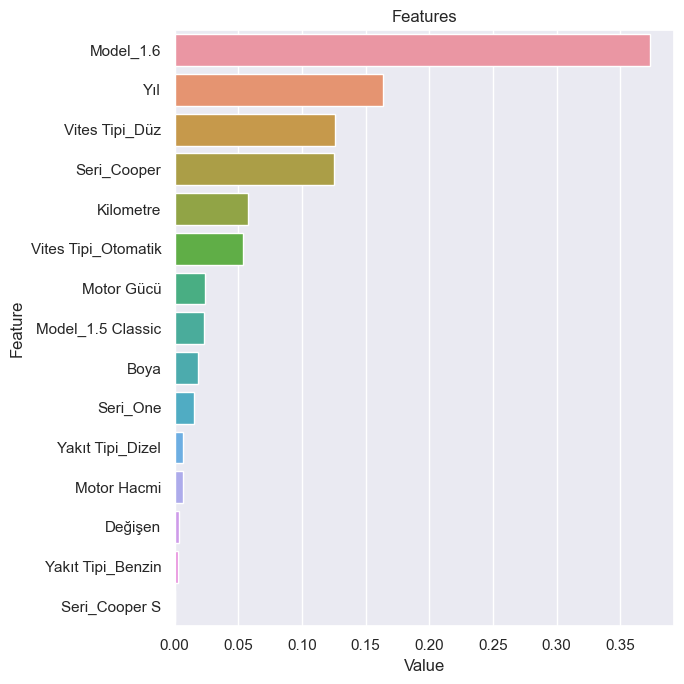

In [18]:
def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(7, 7))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:15])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")
plot_importance(grid_final_model,X)